<a href="https://colab.research.google.com/github/fabnancyuhp/DEEP-LEARNING/blob/main/NOTEBOOKS/time_series_forcasting_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Data Preparation
Univariate time series are datasets comprised of a single series of observations with a temporal ordering and a model is required to learn from the series of past observations to predict the next value in the sequence.

For exemple the univariate sequence $[x_{1},x_{2},x_{3},x_{4},x_{5},x_{6},x_{7},x_{8}]$. We can divide the sequence into multiple input/output patterns called samples, where three time steps are used as input and one time step is used as output for the one-step prediction that is being learned. The features matrix X and the target values Y are
$$\begin{array}{llllll} 
X      &        &      &  & &Y\\
x_{1}, & x_{2}, & x_{3}&  & &x_{4}\\
x_{2}, & x_{3}, & x_{4}&  & &x_{5}\\
x_{3}, & x_{4}, & x_{5}&  & &x_{6}\\
x_{4}, & x_{5}, & x_{6}&  & &x_{7}\\
x_{5}, & x_{6}, & x_{7}&  & &x_{8}
\end{array}$$


Here, we divide the sequence $[x_{1},x_{2},x_{3},x_{4},x_{5},x_{6},x_{7},x_{8},x_{9},x_{10}]$ into multiple input/output patterns, where four time steps are used as input and two time step is used as output for the two_step prediction that is being learned, we get:
$$\begin{array}{lllllll} 
X      &        &      &  & & &Y\\
x_{1}, & x_{2}, & x_{3}&x_{4}  & & &x_{6}\\
x_{2}, & x_{3}, & x_{4}&x_{5}  & & &x_{7}\\
x_{3}, & x_{4}, & x_{5}&x_{6}  & & &x_{8}\\
x_{4}, & x_{5}, & x_{6}&x_{7}  & & &x_{9}\\
x_{5}, & x_{6}, & x_{7}&x_{8}  & & &x_{10}
\end{array}$$

In the above cell, we show a function able to divide a gven sequence into multiple input/output patterns. The argument of split_sequence function are:
* Raw_list is a python list modelizing the sequence
* n_steps : number time steps used as input 

In [ ]:
import numpy as np

#Raw_list is a python list modelising the sequence 
#n_steps : number time steps used as input 
def split_sequence(raw_seq,n_steps):
    X = []
    y = []
    for i in range(len(raw_seq)):
        end_ix = i + n_steps
        if end_ix<=len(raw_seq)-1:
            X.append(raw_seq[i:end_ix])
            y.append(raw_seq[end_ix])
    return np.array(X),np.array(y)

We try the function split_sequence.

In [ ]:
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
n_steps = 3

split_sequence(raw_seq,n_steps)[0]

array([[10, 20, 30],
       [20, 30, 40],
       [30, 40, 50],
       [40, 50, 60],
       [50, 60, 70],
       [60, 70, 80]])

In [ ]:
split_sequence(raw_seq,n_steps)[1]

array([40, 50, 60, 70, 80, 90])

Here, we make a function able to handle a n step prediction problem.
* n_steps are used for the input
* n_steps_pred is used for the output

If we want to make a model that predict a stock price a week later with the last 30 stock price values we set n_steps = 30 and n_steps_pred=7.

In [ ]:
import numpy as np

def split_sequence_bis(raw_seq,n_steps,n_steps_pred):
    X = []
    y = []
    for i in range(len(raw_seq)):
        end_ix = i + n_steps 
        end_iy = i + n_steps +n_steps_pred-1
        if (end_iy<=len(raw_seq)-1):
            X.append(raw_seq[i:end_ix])
            y.append(raw_seq[end_iy])
    return np.array(X),np.array(y)

split_sequence_bis(raw_seq,4,3)

(array([[10, 20, 30, 40],
        [20, 30, 40, 50],
        [30, 40, 50, 60]]), array([70, 80, 90]))

# Renault SA stock price prediction
In the dataset Renault_Stock_prices we store some times series about the Renault stock price. In this example, we want to build a model to predict the closing price of the stock price from its previous 12 closing values.

## Load data
Renault_Stock_prices is a dataset of Renault stock prices from 2000-01-03 to 2021-12-07. We get ride of the data older than 2018. We keep the closing stock price since we want to built a model to predict it.

In [ ]:
#!pip install yfinance
#import yfinance as yf
#tickers=['TSLA'] AAPL  RNO.PA
#tickers = ['RNO.PA']
#data = yf.download(tickers[0]) 

import pandas as pd
file = "https://raw.githubusercontent.com/fabnancyuhp/DEEP-LEARNING/main/DATA/RENAULT.parquet"
Renault_Stock_prices = pd.read_parquet(file)
Renault_Stock_prices = Renault_Stock_prices.loc[Renault_Stock_prices.index.year>=2018][['Close']]

Renault_Stock_prices.head()

,Close
Date,
2018-01-02,83.800003
2018-01-03,84.089996
2018-01-04,85.220001
2018-01-05,87.199997
2018-01-08,88.470001


## Vilualize the price of the closing price history

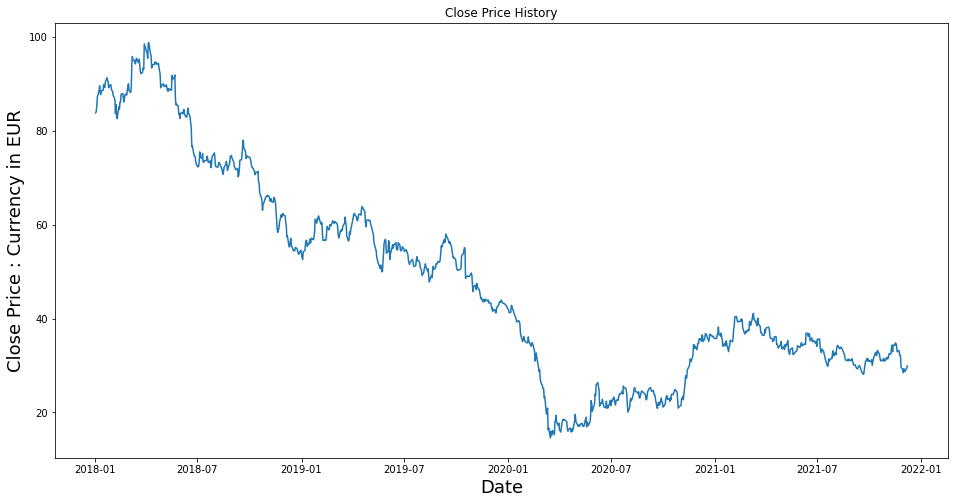

In [ ]:


import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(Renault_Stock_prices['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price : Currency in EUR',fontsize=18)
plt.show()

## Divide data into train and test sets

In [ ]:
train = Renault_Stock_prices.loc[Renault_Stock_prices.index < '2021-08-01']
test = Renault_Stock_prices.loc[Renault_Stock_prices.index >= '2021-08-01']


## Normalize training data
To produce the best-optimized results with the models, we are required to scale the data. For this task, we are leveraging scikit-learn library’s minmax scaler for converting the input values between 0 to 1.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(train['Close'].values.reshape(-1,1))

## Create supervised data with 12 inputs and 1 output
We are working with a univariate series, so the number of features is one, for one variable. When we are working with LSTM’s, we need to keep the data in a specific format. Once the data is created in the form of 12 timesteps. Finally, the data is converted to a 3D dimension array, 12 timeframes, and also one feature at each step.<br><br>
The number of time steps as input is the number we chose when preparing our dataset as an argument to the split_sequence() function.<br><br>
The shape of the input for each sample is specified in the input_shape argument on the definition of first hidden layer.<br><br>
We almost always have multiple samples, therefore, the model will expect the input component of training data to have the dimensions or shape: [samples, timesteps, features].

In [ ]:
import numpy as np

n_features = 1
n_lag = 12

X_train, y_train = split_sequence(train_scaled.ravel().tolist(),n_lag)

X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],n_features))

## Build and train Vanilla LSTM
A Vanilla LSTM is an LSTM model that has a single hidden layer of LSTM units, and an output layer used to make a prediction. Now it’s time to build our LSTM, for this purpose we will load certain Keras modules – Sequential, Dense, LSTM, and Dropout.<br>
We compile the model with the help of adam optimizer. The error is computed using mean_squared_error.  The model is fit using 300 epochs with a batch size of 32.

In [ ]:
#Loading Keras LSTM and Other Modules
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop

#Building the Vanilla LSTM 
Vanilla_LSTM = Sequential()
Vanilla_LSTM.add(LSTM(units = 50,activation='relu',input_shape=(X_train.shape[1],1)))
Vanilla_LSTM.add(Dense(1))


#Compile the model
#opt = RMSprop(lr=0.0001)
Vanilla_LSTM.compile(optimizer = 'adam', loss = 'mse')

#Train the model
Vanilla_LSTM.fit(X_train,y_train,epochs = 300,verbose=0)

## Prepare test set
For predicting the stock prices, the test set should contain the 12 last rows of the training set. The timestep is set to 12, we also apply MinMaxScaler on the new dataset and lastly, the dataset is reshaped.

In [ ]:
inputs  = Renault_Stock_prices[len(Renault_Stock_prices) - len(test) - n_lag:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

n_features = 1
n_lag = 12

X_test, y_test = split_sequence(inputs.ravel().tolist(),n_lag)

X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],n_features))

## Forecast future values

In [ ]:
predict_scaled = Vanilla_LSTM.predict(X_test)
predict = sc.inverse_transform(predict_scaled)

predict = pd.DataFrame(predict)
predict.columns = ['Dernier']
predict.index = test.index

## Evaluate the model

In [ ]:
Vanilla_LSTM.evaluate(X_test,y_test)

3/3 [==============================] - 0s 9ms/step - loss: 6.7640e-05


6.764020508853719e-05

## Plotting the Results

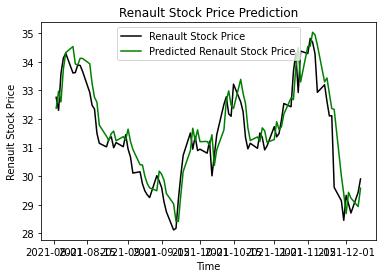

In [ ]:
import matplotlib.pyplot as plt

plt.plot(test, color = 'black', label = 'Renault Stock Price')
plt.plot(predict, color = 'green', label = 'Predicted Renault Stock Price')
plt.title('Renault Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Renault Stock Price')
plt.legend()
plt.show()

## Stacked LSTM 
Multiple hidden LSTM layers can be stacked one on top of another in what is referred to as a Stacked LSTM model.<br><br>
An LSTM layer requires a three-dimensional input and LSTMs by default will produce a two-dimensional output as an interpretation from the end of the sequence.<br><br>
We can address this by having the LSTM output a value for each time step in the input data by setting the return_sequences=True argument on the layer. This allows us to have 3D output from hidden LSTM layer as input to the next.

In [ ]:
#Loading Keras LSTM and Other Modules
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop

#Building the Vanilla LSTM 
STACKED_LSTM = Sequential()
STACKED_LSTM.add(LSTM(units = 50,activation='relu',input_shape=(X_train.shape[1],1),return_sequences=True))
STACKED_LSTM.add(LSTM(units = 50,activation='relu'))
STACKED_LSTM.add(Dense(1))


#Compile the model
opt = RMSprop(lr=0.0001)
STACKED_LSTM.compile(optimizer = 'adam', loss = 'mse')

#Fit STACKED_LSTM                 
STACKED_LSTM.fit(X_train,y_train,epochs = 300,verbose=0)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


We evaluate the model:

In [ ]:
STACKED_LSTM.evaluate(X_test,y_test)

3/3 [==============================] - 1s 8ms/step - loss: 8.1907e-05


8.190675725927576e-05

We forecast future values and plotting the Results

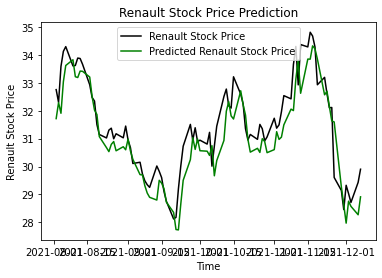

In [ ]:
predict_scaled = STACKED_LSTM.predict(X_test)
predict = sc.inverse_transform(predict_scaled)

predict = pd.DataFrame(predict)
predict.columns = ['Dernier']
predict.index = test.index

import matplotlib.pyplot as plt

plt.plot(test, color = 'black', label = 'Renault Stock Price')
plt.plot(predict, color = 'green', label = 'Predicted Renault Stock Price')
plt.title('Renault Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Renault Stock Price')
plt.legend()
plt.show()

## CNN Model

A one-dimensional CNN is a CNN model that has a convolutional hidden layer that operates over a 1D sequence. This is followed by perhaps a second convolutional layer in some cases, such as very long input sequences, and then a pooling layer whose job it is to distill the output of the convolutional layer to the most salient elements.<br><br>
The convolutional and pooling layers are followed by a dense fully connected layer that interprets the features extracted by the convolutional part of the model. A flatten layer is used between the convolutional layers and the dense layer to reduce the feature maps to a single one-dimensional vector.<br><br>
We can define a 1D CNN Model for univariate time series forecasting as follows.

In [ ]:

from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential


#Building the CNN model 
CNN_MODEL = Sequential()
CNN_MODEL.add(Conv1D(filters=64,kernel_size=2,activation='relu',input_shape=(X_train.shape[1],1)))
CNN_MODEL.add(MaxPooling1D(pool_size=2))
CNN_MODEL.add(Flatten())
CNN_MODEL.add(Dense(50,activation='relu'))
CNN_MODEL.add(Dense(1))

#Compile the model
CNN_MODEL.compile(optimizer = 'adam', loss = 'mse')

#Train the model
CNN_MODEL.fit(X_train,y_train,epochs = 1000,verbose=0,validation_split=0.1)

In [ ]:
CNN_MODEL.evaluate(X_test,y_test)

3/3 [==============================] - 0s 6ms/step - loss: 1.8193e-04


0.00018193406867794693

We forecast future values and plotting the Results

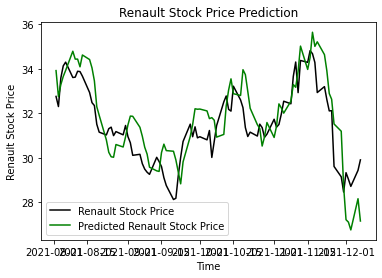

In [ ]:
predict_scaled = CNN_MODEL.predict(X_test)
predict = sc.inverse_transform(predict_scaled)

predict = pd.DataFrame(predict)
predict.columns = ['Dernier']
predict.index = test.index

import matplotlib.pyplot as plt

plt.plot(test, color = 'black', label = 'Renault Stock Price')
plt.plot(predict, color = 'green', label = 'Predicted Renault Stock Price')
plt.title('Renault Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Renault Stock Price')
plt.legend()
plt.show()

# Exercise : Next week stock price prediction
Before, to start this assignment, I recommend you read the above example.<br><br>
The example in this notebook shows you how to design, use deep learning models to predict the stock price the next day. We mainly use LSTM and CNN.<br><br>

We evaluate these models over a test set. We also plot our predicted Stock Price and the Stock price together to have an idea of how well are our model.<br>

**The goal of this exercise is to build models that predict stock price the next week**. In this exercice, you have to : 
* build deep learning models
* Try a model that is not in the field of deep learning like arima.
* Improve the way to  check the efficacity of the models
* compare the models you will build 

The dataset for this exercie could be 
* the one we use in this notebook
* Another daily stock price dataset from a company of your interested 

In the cell below, we show you a way to load the stock price from tesla with the yahoo finance package. You can also follow the following link to have an access to the tesla data:
https://fr.finance.yahoo.com/quote/TSLA/history?p=TSLA



In [ ]:
!pip install yfinance
import yfinance as yf
tickers=['TSLA'] 
data = yf.download(tickers[0]) 

     |████████████████████████████████| 6.4 MB 7.6 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
[*********************100%***********************]  1 of 1 completed


In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500
